<a href="https://colab.research.google.com/github/scridlig-te/transaction-scripting-examples/blob/master/Copy_of_Hackday_Delorean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

Mount Drive and Access to Gsheet "umerged_outages_v1"

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Import Data from Gsheet

In [ ]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1gEUHquVBTl-eIEwcVA44akb30aWbPEhdCqZ7cbkgnqM/edit?usp=sharing')
sheet = wb.worksheet('umerged_outages_v1')
data = sheet.get_all_values()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

raw_df = pd.DataFrame(data)
raw_df.columns = raw_df.iloc[0]
raw_df = raw_df.iloc[1:]
raw_df.head()

,outage_event_id,asn,as_name,catalog_entry,entry_type,is_north_america,is_latin_america,is_emea,is_asia_pacific,outage_datetime,num_interfaces,num_locations,num_root_domains,duration_rounds
1,5d5658a2b55155283e02e143,6939,"Hurricane Electric, Inc.",Hurricane Electric,ISP,TRUE,FALSE,FALSE,FALSE,2019-08-16 07:10:00,3,1,2,1
2,5d565c13eba6210ace81ef5f,26415,VeriSign Global Registry Services,Verisign,DNS,TRUE,FALSE,FALSE,FALSE,2019-08-16 07:25:00,3,1,4,1
3,5d567715de837a880c530dc1,41095,IPTriplePlay Ltd,IPTP Networks,ISP,TRUE,FALSE,FALSE,FALSE,2019-08-16 09:20:00,3,1,2,4
4,5d567715de837a880c530dc0,3356,"Level 3 Communications, Inc.",Century Link,ISP,TRUE,FALSE,FALSE,FALSE,2019-08-16 09:20:00,3,1,2,1
5,5d56782efbb90e076e6560bf,41095,IPTriplePlay Ltd,IPTP Networks,ISP,TRUE,FALSE,FALSE,FALSE,2019-08-16 09:25:00,6,1,6,4


# Prepare Data

In [ ]:
clean_df = raw_df.copy()

In [ ]:
clean_df.head()

,outage_event_id,asn,as_name,catalog_entry,entry_type,is_north_america,is_latin_america,is_emea,is_asia_pacific,outage_datetime,num_interfaces,num_locations,num_root_domains,duration_rounds
1,5d5658a2b55155283e02e143,6939,"Hurricane Electric, Inc.",Hurricane Electric,ISP,TRUE,FALSE,FALSE,FALSE,2019-08-16 07:10:00,3,1,2,1
2,5d565c13eba6210ace81ef5f,26415,VeriSign Global Registry Services,Verisign,DNS,TRUE,FALSE,FALSE,FALSE,2019-08-16 07:25:00,3,1,4,1
3,5d567715de837a880c530dc1,41095,IPTriplePlay Ltd,IPTP Networks,ISP,TRUE,FALSE,FALSE,FALSE,2019-08-16 09:20:00,3,1,2,4
4,5d567715de837a880c530dc0,3356,"Level 3 Communications, Inc.",Century Link,ISP,TRUE,FALSE,FALSE,FALSE,2019-08-16 09:20:00,3,1,2,1
5,5d56782efbb90e076e6560bf,41095,IPTriplePlay Ltd,IPTP Networks,ISP,TRUE,FALSE,FALSE,FALSE,2019-08-16 09:25:00,6,1,6,4


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

The following functions clean and reshape the data to prepare it for analysis.

In [ ]:
#this function ensures all values are numeric and it handles missing values
def clean_that_data(df):
  df.replace(['FALSE','TRUE'], [0,1], inplace=True) #convert booleans to integers

  df = df[~(df.duration_rounds == '')] #remove blank values
  df = df[~(df.num_interfaces == '')]
  df = df[~(df.num_locations == '')]
  df = df[~(df.num_root_domains == '')]
  df = df[~(df.entry_type == '')]
  #convert objects to numeric values
  dtype_dict = {'num_interfaces':'int64',
              'num_locations':'int64',
              'num_root_domains':'int64',
              'duration_rounds':'int64'}
  df = df.astype(dtype_dict)

  return df

In [ ]:
#this function encodes categorical variables 
def encode_cat(df):
  encoder = OneHotEncoder(sparse=False)
  result = encoder.fit_transform(df[['entry_type']])
  encoded_df = pd.DataFrame(result, columns=encoder.get_feature_names())

  return encoded_df

In [ ]:
#this functions pieces together the results of the above functions and outputs the final dataframe
def create_final_df(raw_df):
  cleaned_df = clean_that_data(raw_df)
  encoded_df = encode_cat(raw_df)
  #merge above dfs
  final_df = cleaned_df.merge(encoded_df, left_index=True, right_index=True)

  return final_df

In [ ]:
final_df = create_final_df(clean_df)

In [ ]:
final_df.head()

,outage_event_id,asn,as_name,catalog_entry,entry_type,is_north_america,is_latin_america,is_emea,is_asia_pacific,outage_datetime,num_interfaces,num_locations,num_root_domains,duration_rounds,x0_,x0_CDN,x0_DNS,x0_DNS-CDN-IAAS,x0_IAAS,x0_ISP,x0_SECAAS,x0_UCAAS,x0_UCAAS-IAAS
1,5d5658a2b55155283e02e143,6939,"Hurricane Electric, Inc.",Hurricane Electric,ISP,1,0,0,0,2019-08-16 07:10:00,3,1,2,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5d565c13eba6210ace81ef5f,26415,VeriSign Global Registry Services,Verisign,DNS,1,0,0,0,2019-08-16 07:25:00,3,1,4,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,5d567715de837a880c530dc1,41095,IPTriplePlay Ltd,IPTP Networks,ISP,1,0,0,0,2019-08-16 09:20:00,3,1,2,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5d567715de837a880c530dc0,3356,"Level 3 Communications, Inc.",Century Link,ISP,1,0,0,0,2019-08-16 09:20:00,3,1,2,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,5d56782efbb90e076e6560bf,41095,IPTriplePlay Ltd,IPTP Networks,ISP,1,0,0,0,2019-08-16 09:25:00,6,1,6,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
final_df.describe()

,is_north_america,is_latin_america,is_emea,is_asia_pacific,num_interfaces,num_locations,num_root_domains,duration_rounds,x0_,x0_CDN,x0_DNS,x0_DNS-CDN-IAAS,x0_IAAS,x0_ISP,x0_SECAAS,x0_UCAAS,x0_UCAAS-IAAS
count,52757.000000,52757.000000,52757.000000,52757.000000,52757.000000,52757.000000,52757.000000,52757.000000,52757.000000,52757.000000,52757.000000,52757.000000,52757.000000,52757.000000,52757.000000,52757.000000,52757.000000
mean,0.714730,0.025835,0.406922,0.221582,28.446746,4.551567,49.897625,4.601115,0.002331,0.009553,0.002483,0.012548,0.023201,0.858142,0.056732,0.011221,0.023788
std,0.451547,0.158646,0.491265,0.415315,40.974253,5.116148,87.437335,4.241568,0.048229,0.097274,0.049769,0.111314,0.150542,0.348908,0.231332,0.105335,0.152391
min,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,12.000000,2.000000,9.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,32.000000,6.000000,52.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,273.000000,26.000000,841.000000,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52757 entries, 1 to 53058
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   outage_event_id   52757 non-null  object 
 1   asn               52757 non-null  object 
 2   as_name           52757 non-null  object 
 3   catalog_entry     52757 non-null  object 
 4   entry_type        52757 non-null  object 
 5   is_north_america  52757 non-null  int64  
 6   is_latin_america  52757 non-null  int64  
 7   is_emea           52757 non-null  int64  
 8   is_asia_pacific   52757 non-null  int64  
 9   outage_datetime   52757 non-null  object 
 10  num_interfaces    52757 non-null  int64  
 11  num_locations     52757 non-null  int64  
 12  num_root_domains  52757 non-null  int64  
 13  duration_rounds   52757 non-null  int64  
 14  x0_               52757 non-null  float64
 15  x0_CDN            52757 non-null  float64
 16  x0_DNS            52757 non-null  float6

# Explore Data

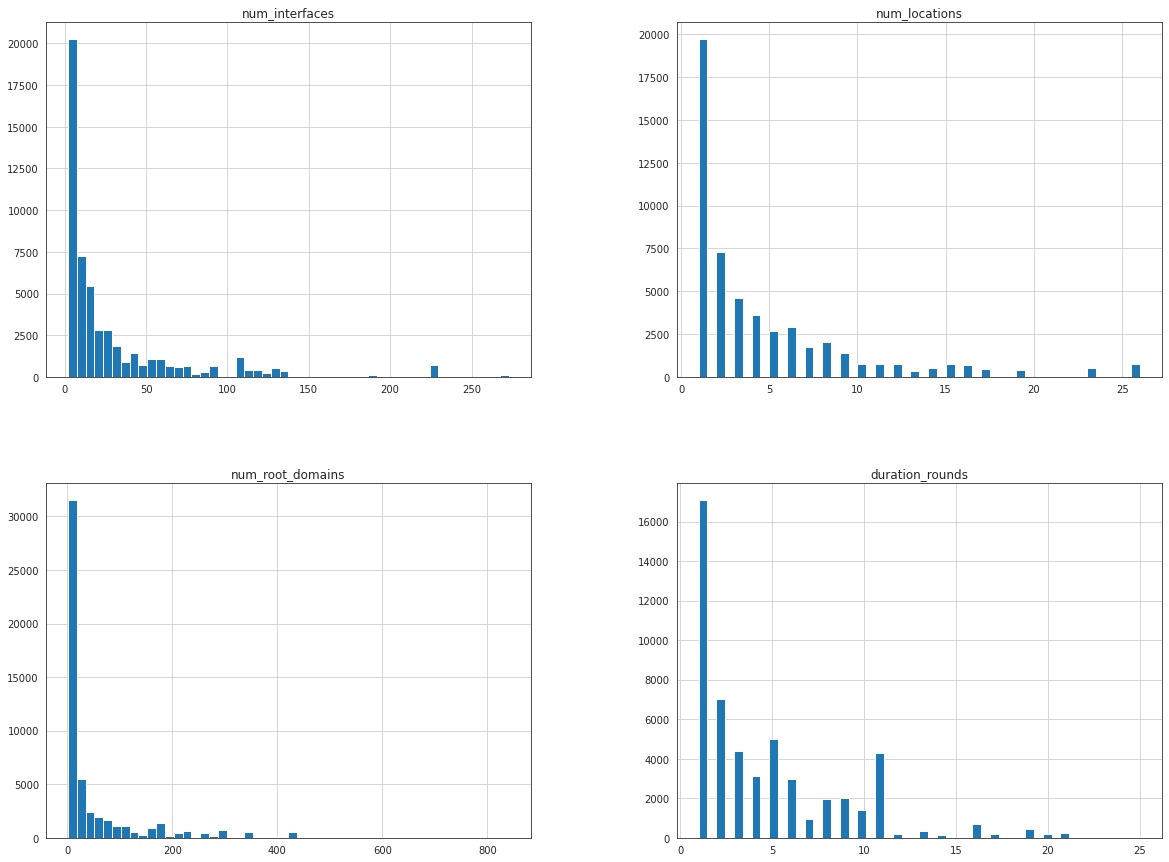

In [ ]:
final_df[['num_interfaces', 'num_locations', 'num_root_domains', 'duration_rounds']].hist(bins=50, figsize=(20,15))
plt.show()

Skews are to expected - will need to normalize later

In [ ]:
final_df.groupby(['is_north_america']).duration_rounds.describe()

,count,mean,std,min,25%,50%,75%,max
is_north_america,,,,,,,,
0,15050.0,2.647375,2.994420,1.0,1.0,1.0,3.0,25.0
1,37707.0,5.380911,4.411515,1.0,2.0,4.0,8.0,21.0


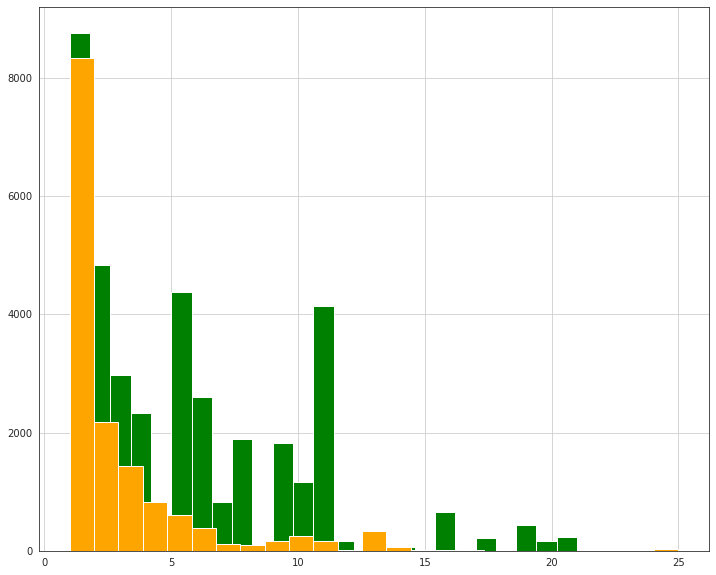

In [ ]:
final_df[final_df.is_north_america == 1].duration_rounds.hist(bins=25, figsize=(12,10), color='green')
final_df[final_df.is_north_america == 0].duration_rounds.hist(bins=25, figsize=(12,10), color='orange')

Seems duration is a bit longer for north american ASNs - not sure if this is due to correlation or because most outages occur in North america

In [ ]:
final_df.is_latin_america.value_counts(normalize=True) #won't include latin america since it's a very small proportion

0    0.974165
1    0.025835
Name: is_latin_america, dtype: float64

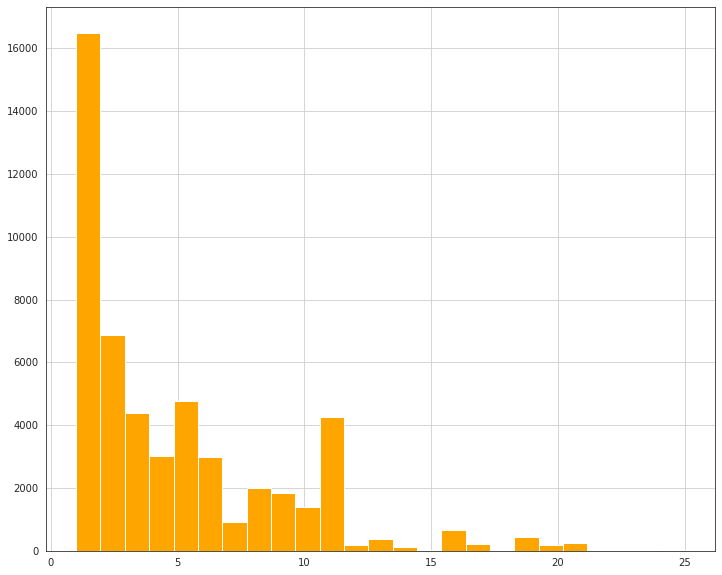

In [ ]:
final_df[final_df.is_latin_america == 1].duration_rounds.hist(bins=25, figsize=(12,10), color='green')
final_df[final_df.is_latin_america == 0].duration_rounds.hist(bins=25, figsize=(12,10), color='orange')

In [ ]:
final_df.is_emea.value_counts(normalize=True) #probably enough to include EMEA

0    0.593078
1    0.406922
Name: is_emea, dtype: float64

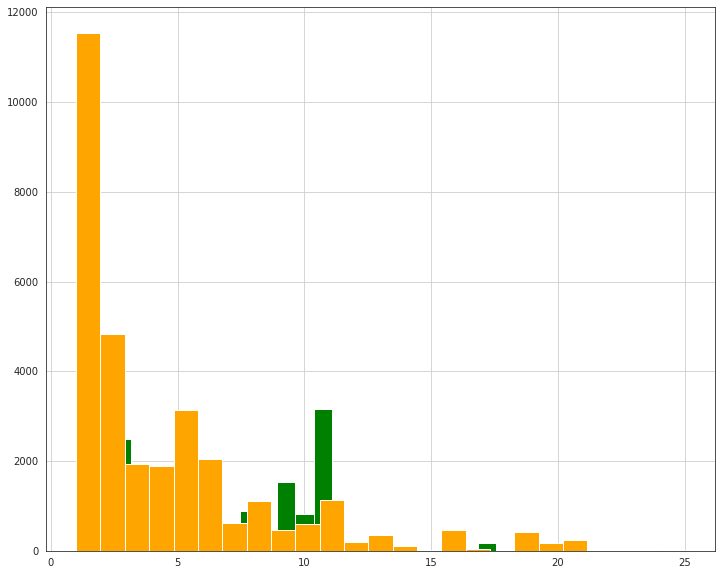

In [ ]:
final_df[final_df.is_emea == 1].duration_rounds.hist(bins=25, figsize=(12,10), color='green')
final_df[final_df.is_emea == 0].duration_rounds.hist(bins=25, figsize=(12,10), color='orange')

In [ ]:
final_df.is_asia_pacific.value_counts(normalize=True) #pretty small but enough to keep for now

0    0.778418
1    0.221582
Name: is_asia_pacific, dtype: float64

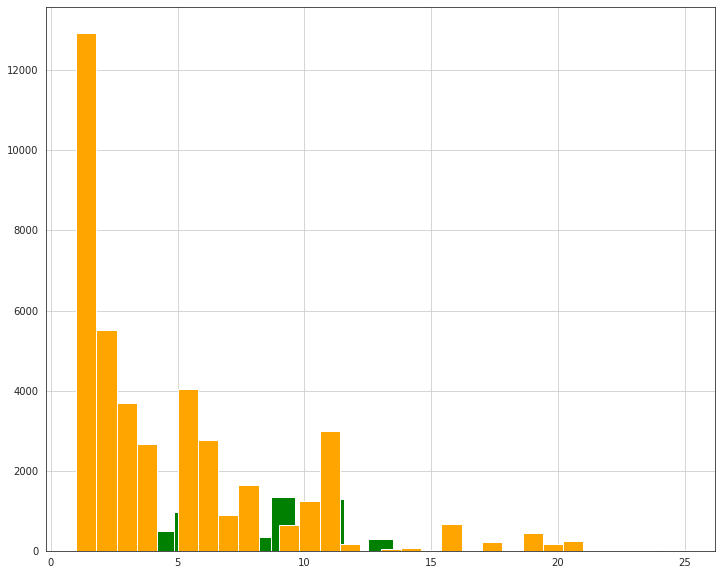

In [ ]:
final_df[final_df.is_asia_pacific == 1].duration_rounds.hist(bins=25, figsize=(12,10), color='green')
final_df[final_df.is_asia_pacific == 0].duration_rounds.hist(bins=25, figsize=(12,10), color='orange')

In [ ]:
len(final_df[final_df.x0_ == 1])

123

In [ ]:
corr_matrix = final_df[['is_north_america', 'is_latin_america', 'is_emea', 'is_asia_pacific', 'num_interfaces', 'num_locations',
       'num_root_domains', 'duration_rounds', 'x0_', 'x0_CDN', 'x0_DNS',
       'x0_DNS-CDN-IAAS', 'x0_IAAS', 'x0_ISP', 'x0_SECAAS', 'x0_UCAAS',
       'x0_UCAAS-IAAS']].corr()

In [ ]:
corr_matrix['duration_rounds'].sort_values(ascending=False)

duration_rounds     1.000000
is_north_america    0.291006
num_locations       0.288784
num_interfaces      0.229054
num_root_domains    0.212163
is_emea             0.111356
x0_ISP              0.089783
x0_                 0.008531
x0_UCAAS-IAAS       0.008317
is_asia_pacific     0.006079
x0_CDN             -0.012219
x0_DNS             -0.020630
x0_DNS-CDN-IAAS    -0.024206
x0_UCAAS           -0.025704
is_latin_america   -0.043727
x0_SECAAS          -0.057687
x0_IAAS            -0.079995
Name: duration_rounds, dtype: float64

In [ ]:
corr_matrix['is_north_america'].sort_values(ascending=False)

is_north_america    1.000000
num_locations       0.394098
num_interfaces      0.322060
num_root_domains    0.302653
duration_rounds     0.291006
x0_ISP              0.132470
x0_CDN              0.025796
x0_                 0.008781
x0_DNS             -0.019087
x0_IAAS            -0.027558
x0_UCAAS           -0.027944
x0_SECAAS          -0.075704
x0_UCAAS-IAAS      -0.079606
is_latin_america   -0.092923
x0_DNS-CDN-IAAS    -0.103009
is_emea            -0.110214
is_asia_pacific    -0.309008
Name: is_north_america, dtype: float64

In [ ]:
import seaborn as sns

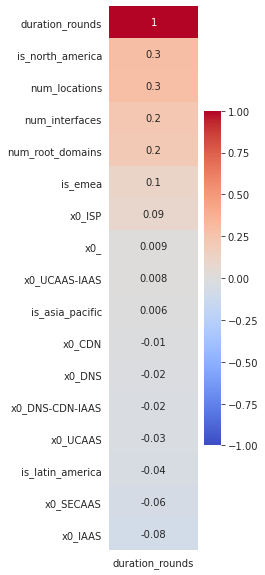

In [ ]:
#fig, ax = plt.subplots()
ax = plt.subplots(figsize=(2,10))
ax = sns.heatmap(corr_matrix[['duration_rounds']].sort_values(by='duration_rounds', ascending=False), annot=True, fmt='.1g', vmin=-1, vmax=1, cmap='coolwarm') 
plt.show()

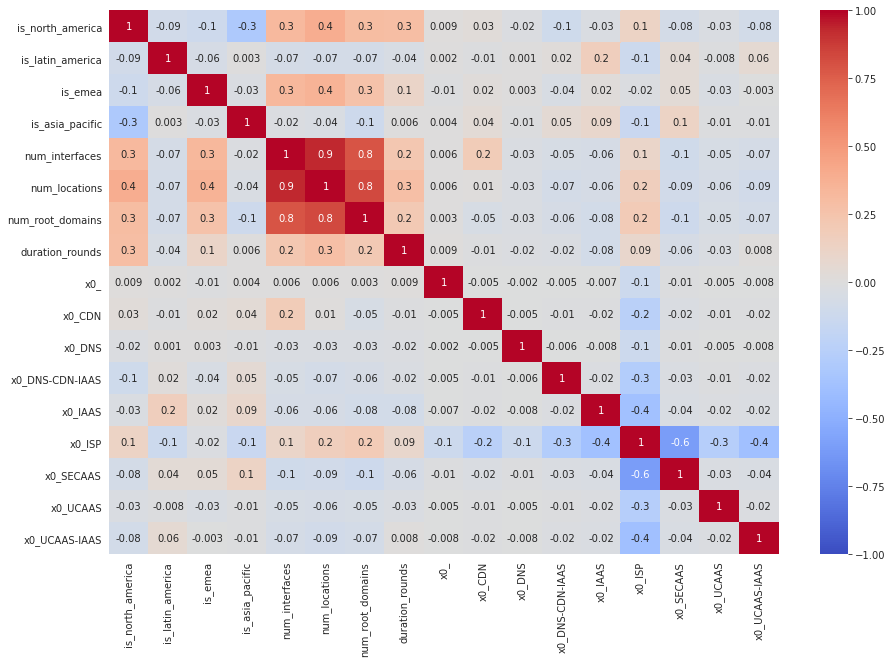

In [ ]:
ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix, annot=True, fmt='.1g', vmin=-1, vmax=1, cmap='coolwarm') 
plt.show()

In [ ]:
final_df.head()

,outage_event_id,asn,as_name,catalog_entry,entry_type,is_north_america,is_latin_america,is_emea,is_asia_pacific,outage_datetime,num_interfaces,num_locations,num_root_domains,duration_rounds,x0_,x0_CDN,x0_DNS,x0_DNS-CDN-IAAS,x0_IAAS,x0_ISP,x0_SECAAS,x0_UCAAS,x0_UCAAS-IAAS
1,5d5658a2b55155283e02e143,6939,"Hurricane Electric, Inc.",Hurricane Electric,ISP,1,0,0,0,2019-08-16 07:10:00,3,1,2,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5d565c13eba6210ace81ef5f,26415,VeriSign Global Registry Services,Verisign,DNS,1,0,0,0,2019-08-16 07:25:00,3,1,4,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,5d567715de837a880c530dc1,41095,IPTriplePlay Ltd,IPTP Networks,ISP,1,0,0,0,2019-08-16 09:20:00,3,1,2,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5d567715de837a880c530dc0,3356,"Level 3 Communications, Inc.",Century Link,ISP,1,0,0,0,2019-08-16 09:20:00,3,1,2,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,5d56782efbb90e076e6560bf,41095,IPTriplePlay Ltd,IPTP Networks,ISP,1,0,0,0,2019-08-16 09:25:00,6,1,6,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Train models and make the prediction

### Split Data

> Indented block



In [ ]:
from sklearn.model_selection import train_test_split

# From our final_df cleaned dataset, seperate the features from the target
x = final_df[['x0_ISP', 'is_emea', 'is_north_america', 'num_interfaces', 'num_locations', 'num_root_domains']].copy()
y = final_df[['duration_rounds']].copy()

# Split data between train and test sets
# random_state is optional and seeds the randomisation for the split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Training Model A : Linear Regression

> Indented block



In [ ]:
from sklearn.linear_model import LinearRegression

# Create the model object
linear_regression = LinearRegression()

# Train the model
linear_regression.fit(x_train, y_train)

# Print coefficients
print('Coefficients: \n', linear_regression.coef_)

Coefficients: 
 [[ 0.27970706  0.61189418  2.03073971 -0.02189607  0.35222146 -0.00306955]]


Predict test results based on Model A

In [ ]:
# Predict with the test data
y_lr_prediction = linear_regression.predict(x_test)
y_lr_prediction_rounded = np.rint(y_lr_prediction).tolist()

# Calculate MSRE
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_lr_prediction_rounded)

15.507865807429871

### Training Model B : Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Create the model object
decision_regressor = DecisionTreeRegressor(random_state = 0)

# Train the model
decision_regressor.fit(x_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

Predict test results based on Model B

In [ ]:
# Predict with the test data
y_dt_prediction = decision_regressor.predict(x_test)
y_dt_prediction_rounded = np.rint(y_dt_prediction).tolist()
#print(y_test)
#print(y_dt_prediction)

# Calculate F1 score
from sklearn.metrics import f1_score
f1_score(y_test,y_dt_prediction_rounded,average='weighted')

0.6398939386151444

### Training Model C : KNN

In [ ]:
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

# Create the model object
neigh_regresser = KNeighborsClassifier(n_neighbors=2)

# Train the model
neigh_regresser.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [ ]:
# Train the model
y_neigh_prediction = neigh_regresser.predict(x_test)
y_neigh_prediction_rounded = np.rint(y_neigh_prediction).tolist()

# Calculate F1 score
f1_score(y_test,y_neigh_prediction_rounded,average='weighted')

0.7505560275947462

Pick the most accurate model data : Ensemble

### Training Model D : SVR


In [ ]:
from sklearn.svm import SVR

# Create the model object
svr_regressor = SVR(kernel= 'rbf')
y_train = y_train.duration_rounds.tolist()

# Train the model
svr_regressor.fit(x_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
# Predict with the test data
y_svr_prediction = svr_regressor.predict(x_test)
y_svr_prediction_rounded = np.rint(y_svr_prediction).tolist()

# Calculate F1 score
from sklearn.metrics import f1_score
f1_score(y_test,y_svr_prediction_rounded,average='weighted')

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_svr_prediction_rounded)

15.534021986353299

### Training Model E: Naive Bayes





In [ ]:
from sklearn.naive_bayes import GaussianNB

#train ze model
gnb = GaussianNB()
y_gnb_pred = gnb.fit(x_train, y_train).predict(x_test)


In [ ]:
f1_score(y_test, y_gnb_pred, average='weighted')

0.1894345356859767

In [ ]:
from sklearn.naive_bayes import BernoulliNB
brn = BernoulliNB()

y_brn_pred = brn.fit(x_train, y_train).predict(x_test)


In [ ]:
f1_score(y_test, y_brn_pred, average='weighted')

0.20339870919035513

# Evaluate





## Comparison of model predictions

In [ ]:
linear_msre = mean_squared_error(y_test, y_lr_prediction_rounded)
decision_f1 = f1_score(y_test,y_dt_prediction_rounded,average='weighted')
knn_f1 = f1_score(y_test,y_neigh_prediction_rounded,average='weighted')
svr_msre = mean_squared_error(y_test, y_svr_prediction_rounded)
nb_f1 = f1_score(y_test, y_brn_pred, average='weighted')

results = {"Linear Regression MSRE": linear_msre,
           "Decision Tree F1": decision_f1,
           "KNN F1":knn_f1,
           "SVR MSRE":svr_msre,
           "Naive Bay F1":nb_f1}

for name, metric in results.items():
    print(f'{name:<25}{metric:9.3f}')

Linear Regression MSRE      15.508
Decision Tree F1             0.640
KNN F1                       0.751
SVR MSRE                    15.534
Naive Bay F1                 0.203


## Visualize KNN model prediction

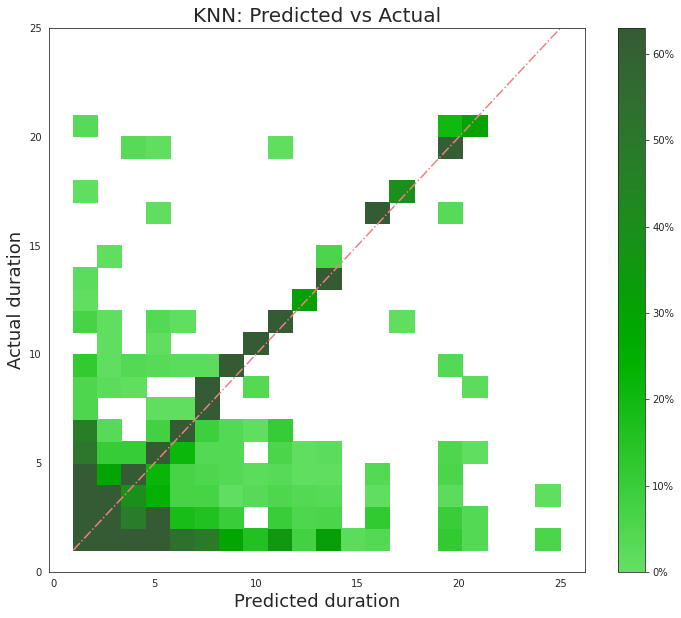

In [ ]:
import seaborn as sns
sns.set_style('white')
plt.figure(figsize=(12,10))

sns.histplot(x=y_test.duration_rounds, y=y_neigh_prediction_rounded,
             bins=20, pmax=.1, color='green',
             cbar=True, cbar_kws=dict(shrink=1, format='%.0f%%')
             )
plt.xlabel('Predicted duration', fontsize=18)
plt.ylabel('Actual duration', fontsize=18)
plt.title('KNN: Predicted vs Actual', fontsize=20)
plt.ylim(top=25)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k-.', lw=1.5, color='lightcoral')
plt.show()